<a href="https://colab.research.google.com/github/lomvn/RNN-LSTM-GRU/blob/main/6_7_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Бинарная классификация текста с использованием архитектур RNN, LSTM и GRU

Датасет FakeNewsNet.csv

https://www.kaggle.com/datasets/algord/fake-news

In [4]:
!pip install torchtext==0.6
#!pip install gensim
#conda install "scipy<1.13"
#conda install -c anaconda scipy=1.12
#!pip install scipy==1.12

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 5.4 MB/s eta 0:00:00


In [ ]:
# каталог среды исполнения...
import sys
print(sys.executable)
print(sys.version)

/usr/bin/python3
3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]


In [ ]:
import scipy
print(scipy.__version__)

1.13.1


In [2]:
import gensim
from gensim.models import Word2Vec

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import random
import matplotlib.pyplot as plt
import seaborn as sns
import string

import torchtext.data as data
from torchtext.data import Field, LabelField
from torchtext.data import BucketIterator
from tqdm import tqdm

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf

from keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
from keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.modules.rnn")

In [ ]:
df1 = pd.read_csv(r'sample_data/FakeNewsNet.csv', encoding='utf-8')

In [ ]:
print(df1.shape)
df1.head()

(23196, 5)


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


In [ ]:
# Проверяем на наличие null-значений (при наличии удаляем...)
df1.isnull().sum()

,0
title,0
news_url,330
source_domain,330
tweet_num,0
real,0


In [ ]:
df = df1.dropna()
print(df.shape)
df.head()

(22866, 5)


,title,news_url,source_domain,tweet_num,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,42,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,0,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,63,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,20,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,38,1


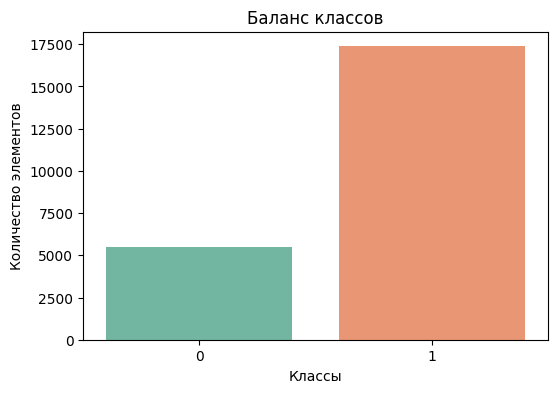

In [ ]:
# смотрим баланс классов real(статьи  реальные, фейк)
class_counts = df['real'].value_counts()

# Визуализация графика баланса классов
plt.figure(figsize=(6, 4))
sns.countplot(x='real', data=df, hue='real', palette='Set2', legend=False)
plt.title('Баланс классов')
plt.xlabel('Классы')
plt.ylabel('Количество элементов')
plt.show()

In [ ]:
df.dtypes

,0
title,object
news_url,object
source_domain,object
tweet_num,int64
real,int64


In [ ]:
# выбераем для работы столбцы ['title','news_url','source_domain','real'] tweet_num - удаляем
df = df.drop('tweet_num', axis=1)
print(df.shape)
df.head()

(22866, 4)


,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [ ]:
# текст из столбцов ['title','news_url','source_domain'] в один столбец ‘text’
df['text'] = df[['title', 'news_url', 'source_domain']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

print(df.shape)
df.head()

(22866, 5)


,title,news_url,source_domain,real,text
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1,Kandi Burruss Explodes Over Rape Accusation on...
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1,People's Choice Awards 2018: The best red carp...
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1,Colombian singer Maluma sparks rumours of inap...
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [ ]:
# удаляем ненужные
df = df.drop(['title', 'news_url', 'source_domain'], axis=1)
print(df.shape)
df.head()
# Порядок столбцов!!!

(22866, 2)


,real,text
0,1,Kandi Burruss Explodes Over Rape Accusation on...
1,1,People's Choice Awards 2018: The best red carp...
2,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,1,Colombian singer Maluma sparks rumours of inap...
4,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [ ]:
df['real'].value_counts()

,count
real,
1,17371
0,5495


### Определите поля TEXT и LABEL, затем, используя эти переменные, создайте датасет и постройте словари

In [ ]:
# Делаем предобработку данных, определяем поля (fields)
# TEXT - поле для текста, параметры: sequential=True данные являются последовательными (текст), tokenize='spacy тест доллжен быть токенизирован
# с помощью spacy lower=True - весь текст в нижний регистр
# В LABEL - LabelField(dtype=torch.float тип данных должен быть float

TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [ ]:
# Подготовка примеров данных? создаем список text, label
# Для каждой строки в DataFrame df создается новый пример данных,
# где text - это текст из столбца 'text',
# а label - метка из столбца 'real'. Эти примеры добавляются в список examples
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [ ]:
# создаем Dataset
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [ ]:
# использование random.seed(SEED) перед вызовом split гарантирует воспроизводимость результатов (лучше чем просто random_state=42)
SEED = 42
random.seed(SEED)
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [ ]:
# Построение словаря с помощью build_vocab на основе тренировочных данных.
# Это означает, что создаются уникальные идентификаторы для каждого уникального слова в тексте
# и для каждого уникального значения метки

# TEXT.build_vocab(train_data)
# LABEL.build_vocab(train_data)

# print(f"размер TEXT vocab: {len(TEXT.vocab)}")
# print(f"размер LABEL vocab: {len(LABEL.vocab)}")

размер TEXT vocab: 35944
размер LABEL vocab: 2


In [ ]:
TEXT.build_vocab(train_data, max_size=200) # для embedding_dim = 200 при использовании Word2Vec
LABEL.build_vocab(train_data)

In [ ]:
# Определение BATCH_SIZE и указание, что при наличии GPU вычисления будут выполняться на нём
# больший размер пакета (например, 50 или 100) может привести к более стабильному обучению, но - память, ресурсы...
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Создаём итератор для обучения и тестирования модели с использованием BucketIterator.
# sort_within_batch - данные внутри пакета отсортированы по длине (для эффективности обучения)
# sort_key ключ сортировки указывает какие данные сортировать внутри каждого пакета (в данном случае по длине текста)
# Эти итераторы используются для подачи данных в модель во время обучения и тестирования
train_iterator, test_iterator = BucketIterator.splits(
    (train_data, test_data),
    batch_size=BATCH_SIZE,
    device=device,
    sort_within_batch=True,
    sort_key=lambda x: len(x.text))

### Обучите модель w2v для векторизации текста с использованием from gensim.models import Word2Vec

In [ ]:
# Делаем предобучение модели Word2Vec
# создается список списков слов (предложений), где каждый внутренний список представляет собой предложение.
# этот список используется для обучения модели Word2Vec

sentences = [[word for word in example.text] for example in train_data.examples]
#sentences = df['text'].tolist() # можно и так...

# embedding_dim должно быть меньше или равно размеру нашего словаря
# если мы используем предварительно обученные векторы слов, такие как Word2Vec или GloVe, размерность векторов слов уже определена
# (например, 50, 100, 200 или 300) В этом случае мы можем использовать ту же размерность для своего Embedding-слоя
embedding_dim = 200 #  размерность векторов слов

In [ ]:
# Создаем модель Word2Vec
# vector_size- размерность векторов слов
# window=5 - размер окна для выявления соседей слов
# min_count=5 - минимальная частота слова для включения его в модель
# workers=4 - количество процессов для обучения модели
# sg=0 - использует CBOW-алгоритм (0 - CBOW, 1 - Skip-gram)

w2v_model = gensim.models.Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=0)
w2v_model.build_vocab(sentences) # построение словаря для модели Word2Vec на основе списка предложений
w2v_model.train(sentences, total_examples=len(sentences), epochs=10) # обучение модели
w2v_model.save("w2v_model.txt") # сохранение обученной модели в файл

In [ ]:
#загружаем предобученную модель Word2Vec из файла и используем ее для векторизации текста
w2v_model = gensim.models.word2vec.Word2Vec.load("w2v_model.txt")
word2vec_vectors = w2v_model.wv.vectors # извлечение матрицы векторов слов из модели

In [ ]:
#чтобы использовать предобученные векторы Word2Vec в модели, делаем следующее:
# преобразование матрицы векторов слов в Tensor PyTorch
pre_trained_emb = torch.FloatTensor(word2vec_vectors)

# создание Embedding-слоя в PyTorch на основе предварительно обученных векторов слов
# параметр freeze=False означает, что веса Embedding-слоя можно будет обучать во время дальнейшего обучения модели
embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)

In [ ]:
# класс RNN_LSTM с долговременной краткосрочной памятью (LSTM) в PyTorch
# vocab_size: Размер словаря для Embedding-слоя.
# embedding_dim: Размерность Embedding-векторов.
# hidden_dim: Размерность скрытого состояния RNN.
# output_dim: Размерность выходного слоя (количество классов для классификации).
# n_layers: Количество слоев в RNN.
# dropout: Коэффициент dropout для предотвращения переобучения.
# !!! pre_trained_emb: Предварительно обученные Embedding-вектора, используемые для инициализации Embedding-слоя!!!

# self.embedding: Embedding-слой, инициализированный предварительно обученными векторами
# self.rnn: LSTM-слой с параметрами, принимает Embedding-вектора в качестве входных данных и возвращает выходное состояние и последнее скрытое состояние.
# self.fc: Полносвязный слой, который принимает последнее скрытое состояние RNN и возвращает выходное представление,
# соответствующее размерности выходных данных.
# self.dropout: Слой dropout для предотвращения переобучения.

# Прямой проход (forward): Этот метод определяет, как данные проходят через модель.
# Он принимает текстовые данные (индексы слов) и возвращает выходное представление.
# embedded = self.dropout(self.embedding(text)): Embedding-вектора для входных данных (text) с последующим применением dropout.
# output, (hidden, cell) = self.rnn(embedded): Проход Embedding-векторов через LSTM-слой, возвращающий выходные данные (output)
# и последние скрытое состояние (hidden) и состояние ячейки (cell).
# hidden = self.dropout(hidden[0,:,:]): Применение dropout к последнему скрытому состоянию.
# return self.fc(hidden.squeeze(0)): Проход последнего скрытого состояния через полносвязный слой (fc),
# чтобы получить выходное представление. squeeze(0) используется для удаления размерности 1 из тензора hidden

In [ ]:
class RNN_LSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pre_trained_emb):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = dropout, bidirectional=True)
        # Параметр bidirectional=True в инициализации LSTM-слоя (self.rnn) означает, что LSTM будет обучаться в двух направлениях:
        # вперед и назад. При значении bidirectional=True, LSTM одновременно обрабатывает последовательность данных в прямом и обратном направлениях,
        # а затем объединяет результаты этих двух направлений

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)



    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.rnn(embedded)
        #hidden = self.dropout(hidden[-1,:,:])
        hidden = self.dropout(hidden[0,:,:])
        return self.fc(hidden.squeeze(0))


In [ ]:
# vocab_size: размер словаря
# embedding_dim: размерность вектора embeddings для каждого слова 50-300
# hidden_dim: размерность скрытого состояния в вашей модели RNN 100-500
# output_dim: размерность выходного вектора вашей модели
# n_layers: количество слоев в вашей модели RNN
# dropout: параметр, который используется для предотвращения переобучения 0.2-0.5

In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 256
output_dim = 1
n_layers = 1
dropout = 0.5

In [ ]:
# создаем экземпляр модели RNN_LSTM которая принимает индексы слов в качестве входных данных и возвращает выходное представление,
# соответствующее размерности выходных данных (например, количеству классов для классификации)
model = RNN_LSTM(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    dropout,
    pre_trained_emb=pre_trained_emb
)

In [ ]:
# Определяем оптимизатор и функцию потерь
optimizer = optim.Adam(model.parameters())
# определение функции потерь
criterion = nn.BCEWithLogitsLoss() # для задач бинарной классификации
#criterion = nn.CrossEntropyLoss() # выходной слой (self.fc) возвращает вектор фиксированной длины  (2 для бинарной классификации)

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
# Вычисляем accuracy
def binary_accuracy(preds, y):
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()

    all_predictions = []
    all_labels = []

    for batch in iterator:
        # проверяем размерности...
        # print(f"Форма batch.text: {batch.text.shape}, Тип batch.text: {type(batch.text)}")
        # print(f"Форма batch.label: {batch.label.shape}, Тип batch.label: {type(batch.label)}")
        # print(f"Размер вектора embeddings: {embedding_dim}")
        # Ожидаемый вывод:
        # Форма batch.text: torch.Size([30, 100]), Тип batch.text: <class 'torch.LongTensor'>
        # Форма batch.label: torch.Size([30]), Тип batch.label: <class 'torch.LongTensor'>

        optimizer.zero_grad()
        predictions = model(batch.text).squeeze(1)
        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)
    val_acc = binary_accuracy(all_predictions, all_labels)
    val_loss = criterion(all_predictions, all_labels).item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator), val_loss, val_acc.item()

In [ ]:
N_EPOCHS = 10

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
#for epoch in tqdm(range(N_EPOCHS), leave=False):
    train_loss, train_acc, val_loss, val_acc = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


 10%|█         | 1/10 [00:04<00:43,  4.83s/it]

Epoch: 01, Train Loss: 0.489, Train Acc: 79.07%, Val Loss: 0.489, Val Acc: 79.07%


 20%|██        | 2/10 [00:07<00:29,  3.72s/it]

Epoch: 02, Train Loss: 0.442, Train Acc: 81.18%, Val Loss: 0.442, Val Acc: 81.18%


 30%|███       | 3/10 [00:10<00:23,  3.36s/it]

Epoch: 03, Train Loss: 0.432, Train Acc: 81.89%, Val Loss: 0.432, Val Acc: 81.89%


 40%|████      | 4/10 [00:13<00:18,  3.03s/it]

Epoch: 04, Train Loss: 0.421, Train Acc: 82.09%, Val Loss: 0.421, Val Acc: 82.08%


 50%|█████     | 5/10 [00:15<00:14,  2.86s/it]

Epoch: 05, Train Loss: 0.416, Train Acc: 82.35%, Val Loss: 0.416, Val Acc: 82.35%


 60%|██████    | 6/10 [00:18<00:11,  2.76s/it]

Epoch: 06, Train Loss: 0.408, Train Acc: 82.83%, Val Loss: 0.408, Val Acc: 82.82%


 70%|███████   | 7/10 [00:21<00:08,  2.92s/it]

Epoch: 07, Train Loss: 0.402, Train Acc: 83.10%, Val Loss: 0.402, Val Acc: 83.10%


 80%|████████  | 8/10 [00:24<00:05,  2.84s/it]

Epoch: 08, Train Loss: 0.393, Train Acc: 83.71%, Val Loss: 0.392, Val Acc: 83.72%


 90%|█████████ | 9/10 [00:26<00:02,  2.75s/it]

Epoch: 09, Train Loss: 0.387, Train Acc: 83.82%, Val Loss: 0.387, Val Acc: 83.82%


100%|██████████| 10/10 [00:29<00:00,  2.94s/it]

Epoch: 10, Train Loss: 0.377, Train Acc: 84.51%, Val Loss: 0.377, Val Acc: 84.51%


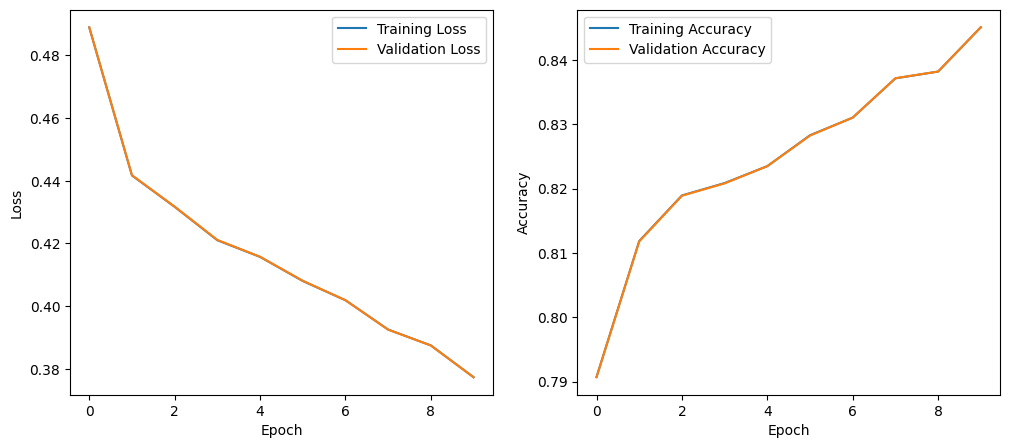

In [ ]:
plt.figure(figsize=(12, 5))

#Loss график ПОТЕРЬ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy график ТОЧНОСТИ
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
# Сохранение модели
#torch.save(model.state_dict(), 'model_pytorch.pt' )

In [ ]:
def evaluate_model(model, iterator):
    all_predictions = []
    all_labels = []

    for batch in tqdm(iterator):
        predictions = model(batch.text).squeeze(1)
        all_predictions += predictions.tolist()
        all_labels += batch.label.tolist()

    all_predictions = torch.tensor(all_predictions)
    all_labels = torch.tensor(all_labels)

    y_pred_binary = torch.round(torch.sigmoid(all_predictions)).cpu().numpy()
    y_true = all_labels.cpu().numpy()

    accuracy = accuracy_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, all_predictions.cpu().numpy())

    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("ROC AUC Score:", roc_auc)

    fpr, tpr, _ = roc_curve(y_true, all_predictions.cpu().numpy())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

100%|██████████| 153/153 [00:00<00:00, 572.70it/s]


Accuracy: 0.8219986879510168
F1 Score: 0.5194805194805194
ROC AUC Score: 0.7985890228174286


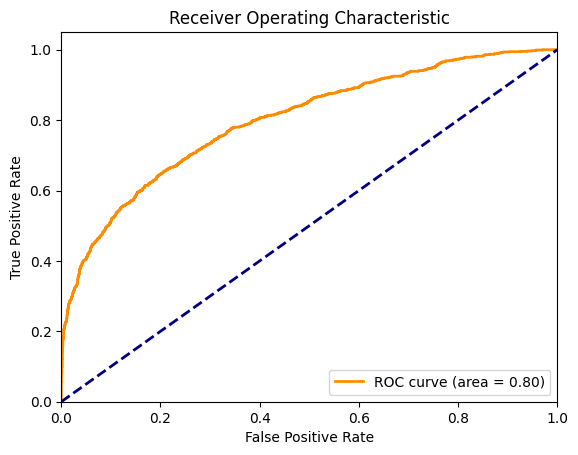

In [ ]:
evaluate_model(model, test_iterator)

In [ ]:
class RNN_GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout, pre_trained_emb):
        super().__init__()
        self.embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)

        self.rnn = nn.GRU(embedding_dim, hidden_dim, n_layers, dropout = dropout, bidirectional=True)

        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)



    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(hidden[0,:,:])
        return self.fc(hidden.squeeze(0))

In [ ]:
vocab_size = len(TEXT.vocab)
embedding_dim = 200
hidden_dim = 256
output_dim = 1
n_layers = 1
dropout = 0.5

In [ ]:
model = RNN_GRU(
    vocab_size,
    embedding_dim,
    hidden_dim,
    output_dim,
    n_layers,
    dropout,
    pre_trained_emb=pre_trained_emb
)

In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()

In [ ]:
model = model.to(device)
criterion = criterion.to(device)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in tqdm(range(N_EPOCHS)):
#for epoch in tqdm(range(N_EPOCHS), leave=False):
    train_loss, train_acc, val_loss, val_acc = train(model, train_iterator, optimizer, criterion)
    print(f'Epoch: {epoch+1:02}, Train Loss: {train_loss:.3f}, Train Acc: {train_acc*100:.2f}%, Val Loss: {val_loss:.3f}, Val Acc: {val_acc*100:.2f}%')

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)


 10%|█         | 1/10 [00:02<00:22,  2.47s/it]

Epoch: 01, Train Loss: 0.488, Train Acc: 79.02%, Val Loss: 0.488, Val Acc: 79.02%


 20%|██        | 2/10 [00:04<00:19,  2.47s/it]

Epoch: 02, Train Loss: 0.440, Train Acc: 81.27%, Val Loss: 0.440, Val Acc: 81.27%


 30%|███       | 3/10 [00:08<00:19,  2.78s/it]

Epoch: 03, Train Loss: 0.430, Train Acc: 81.91%, Val Loss: 0.430, Val Acc: 81.91%


 40%|████      | 4/10 [00:10<00:15,  2.64s/it]

Epoch: 04, Train Loss: 0.421, Train Acc: 82.27%, Val Loss: 0.422, Val Acc: 82.27%


 50%|█████     | 5/10 [00:12<00:12,  2.56s/it]

Epoch: 05, Train Loss: 0.412, Train Acc: 82.58%, Val Loss: 0.412, Val Acc: 82.58%


 60%|██████    | 6/10 [00:15<00:10,  2.51s/it]

Epoch: 06, Train Loss: 0.404, Train Acc: 83.07%, Val Loss: 0.405, Val Acc: 83.06%


 70%|███████   | 7/10 [00:17<00:07,  2.49s/it]

Epoch: 07, Train Loss: 0.395, Train Acc: 83.53%, Val Loss: 0.395, Val Acc: 83.52%


 80%|████████  | 8/10 [00:21<00:05,  2.73s/it]

Epoch: 08, Train Loss: 0.389, Train Acc: 83.95%, Val Loss: 0.389, Val Acc: 83.95%


 90%|█████████ | 9/10 [00:23<00:02,  2.65s/it]

Epoch: 09, Train Loss: 0.373, Train Acc: 84.65%, Val Loss: 0.373, Val Acc: 84.64%


100%|██████████| 10/10 [00:25<00:00,  2.59s/it]

Epoch: 10, Train Loss: 0.363, Train Acc: 85.39%, Val Loss: 0.363, Val Acc: 85.39%


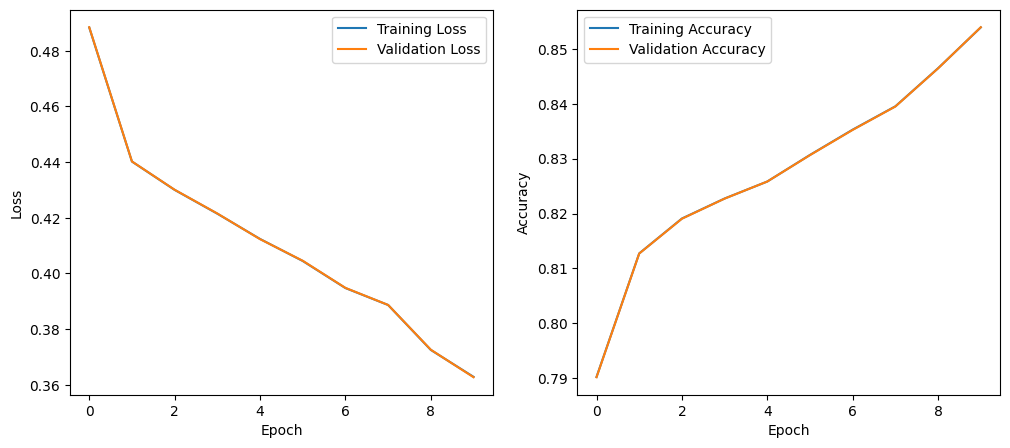

In [ ]:
plt.figure(figsize=(12, 5))

#Loss график ПОТЕРЬ
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#Accuracy график ТОЧНОСТИ
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

100%|██████████| 153/153 [00:00<00:00, 558.81it/s]


Accuracy: 0.8110649464246665
F1 Score: 0.5283842794759825
ROC AUC Score: 0.7899676829229426


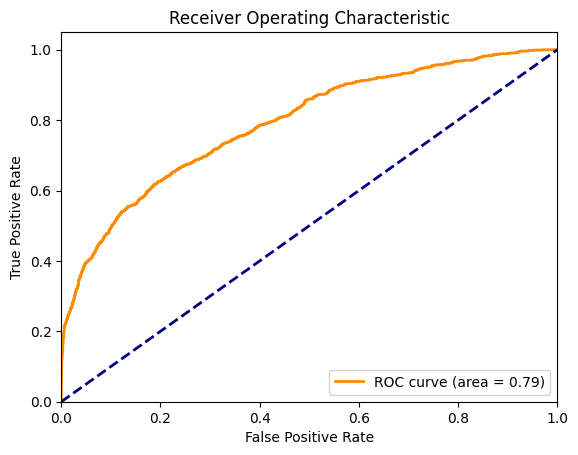

In [ ]:
evaluate_model(model, test_iterator)

## Задачи для TensorFlow

In [7]:
df1 = pd.read_csv(r'sample_data/FakeNewsNet.csv', encoding='utf-8')

In [9]:
df = df1.dropna()

In [10]:
df = df.drop('tweet_num', axis=1)
print(df.shape)
df.head()

(22866, 4)


,title,news_url,source_domain,real
0,Kandi Burruss Explodes Over Rape Accusation on...,http://toofab.com/2017/05/08/real-housewives-a...,toofab.com,1
1,People's Choice Awards 2018: The best red carp...,https://www.today.com/style/see-people-s-choic...,www.today.com,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,https://www.etonline.com/news/220806_sophia_bu...,www.etonline.com,1
3,Colombian singer Maluma sparks rumours of inap...,https://www.dailymail.co.uk/news/article-33655...,www.dailymail.co.uk,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,https://www.zerchoo.com/entertainment/gossip-g...,www.zerchoo.com,1


In [11]:
df['text'] = df[['title', 'news_url', 'source_domain']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [12]:
df = df.drop(['title', 'news_url', 'source_domain'], axis=1)
print(df.shape)
df.head()

(22866, 2)


,real,text
0,1,Kandi Burruss Explodes Over Rape Accusation on...
1,1,People's Choice Awards 2018: The best red carp...
2,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,1,Colombian singer Maluma sparks rumours of inap...
4,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [13]:
# проверяем наличие дубликатов
duplicates = df.duplicated()
print("duplicates:", duplicates.sum())

duplicates: 1201


In [16]:
# удаляем дубликаты
df = df.drop_duplicates()
print("removing duplicates:", df.shape)

removing duplicates: (21665, 2)


In [17]:
print(df.shape)
df.head()

(21665, 2)


,real,text
0,1,Kandi Burruss Explodes Over Rape Accusation on...
1,1,People's Choice Awards 2018: The best red carp...
2,1,Sophia Bush Sends Sweet Birthday Message to 'O...
3,1,Colombian singer Maluma sparks rumours of inap...
4,1,Gossip Girl 10 Years Later: How Upper East Sid...


In [18]:
# Загружаем стоп-слова из библиотеки NLTK
stop_words = set(stopwords.words('english'))

In [19]:
# Проверяем на наличие null-значений (при наличии удаляем...)
df.isnull().sum()

,0
real,0
text,0


In [20]:
# фун-я препроцессинга текста
def preprocess_text(text):
    # Удаляем знаки препинания
    text = text.translate(str.maketrans("", "", string.punctuation))

    # Приводим к нижнему регистру
    text = text.lower()

    # Токенизация текста
    tokens = word_tokenize(text)

    # Удаляем стоп-слова
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Удаляем числа и другие символы
    tokens = [word for word in tokens if word.isalpha()]

    # Склеиваем токены обратно в строку
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [21]:
def preprocess_dataframe(dataframe, text_column):
    # Применяем preprocess_text ко всем значениям в указанной колонке
    dataframe[text_column] = dataframe[text_column].apply(preprocess_text)

    return dataframe

In [23]:
preprocess_dataframe(df, 'text')

,real,text
0,1,kandi burruss explodes rape accusation real ho...
1,1,peoples choice awards best red carpet looks ww...
2,1,sophia bush sends sweet birthday message one t...
3,1,colombian singer maluma sparks rumours inappro...
4,1,gossip girl years later upper east siders shoc...
...,...,...
23190,1,see love actually sequel clip red nose day spe...
23191,1,pippa middleton wedding case missed itpippa ma...
23192,0,zayn malik gigi hadid shocking split chance re...
23193,1,jessica chastain recalls moment mothers boyfri...


In [24]:
# еще раз проверяем наличие дубликатов
duplicates = df.duplicated()
print("duplicates:", duplicates.sum())

duplicates: 123


In [25]:
# удаляем дубликаты
df = df.drop_duplicates()
print("removing duplicates:", df.shape)
print(df.shape)
df.head()

removing duplicates: (21542, 2)
(21542, 2)


,real,text
0,1,kandi burruss explodes rape accusation real ho...
1,1,peoples choice awards best red carpet looks ww...
2,1,sophia bush sends sweet birthday message one t...
3,1,colombian singer maluma sparks rumours inappro...
4,1,gossip girl years later upper east siders shoc...


### обучим модель w2v для векторизации текста с использованием from gensim.models import Word2Vec

In [27]:
TEXT = data.Field(sequential=True, tokenize='spacy', lower=True, tokenizer_language='en_core_web_sm')
LABEL = data.LabelField(dtype=torch.float)

In [29]:
examples = []
for index, row in df.iterrows():
    text = row['text']
    label = row['real']
    examples.append(data.Example.fromlist([text, label], fields=[('text', TEXT), ('label', LABEL)]))

In [30]:
dataset = data.Dataset(examples, fields=[('text', TEXT), ('label', LABEL)])

In [31]:
SEED = 42
random.seed(SEED)
train_data, test_data = dataset.split(split_ratio=0.8, random_state=random.seed(SEED))

In [32]:
TEXT.build_vocab(train_data, max_size=200)
LABEL.build_vocab(train_data)

In [33]:
BATCH_SIZE = 30
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
sentences = [[word for word in example.text] for example in train_data.examples]
embedding_dim = 200

In [35]:
w2v_model = gensim.models.Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=5, workers=4, sg=0)
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=len(sentences), epochs=10)
w2v_model.save("w2v_model.txt")

In [36]:
#загружаем модель Word2Vec и используем ее для векторизации текста
w2v_model = gensim.models.word2vec.Word2Vec.load("w2v_model.txt")
word2vec_vectors = w2v_model.wv.vectors

In [37]:
#предобученные векторы Word2Vec в модели...
pre_trained_emb = torch.FloatTensor(word2vec_vectors)
embedding = nn.Embedding.from_pretrained(pre_trained_emb, freeze=False)

### Создайте токенизатор с помощью from keras.layers.experimental.preprocessing import TextVectorization  и обучите его на предобработанных данных. Преобразуйте текст в последовательность целых чисел с использованием обученного токенизатора

In [ ]:
#!pip install --upgrade tensorflow

In [88]:
#!!!!!!!!!!!!!!!!!!!!!
#df['real'] = df['real'].astype(str)
df['label'] = df['real'].replace({'0': 0, '1': 1})

<ipython-input-88-9ca11de6363b>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['real'].replace({'0': 0, '1': 1})
<ipython-input-88-9ca11de6363b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['real'].replace({'0': 0, '1': 1})


In [92]:
# создаем обьект класса Tokenizer для токенизации текста
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'].tolist())

In [93]:
# Получение словаря (ключи - уникальные слова, значения - индексы)
word_index = tokenizer.word_index

In [95]:
# векторизируем текст с помощью texts_to_sequences
sequences = tokenizer.texts_to_sequences(df['text'].tolist())
data = sequence.pad_sequences(sequences)
print(data)

[[    0     0     0 ...   209    29   610]
 [    0     0     0 ...   103   157   125]
 [    0     0     0 ...  4522 11419     9]
 ...
 [    0     0     0 ...   635   875    22]
 [    0     0     0 ...  4791 11369   556]
 [    0     0     0 ...    73    13   115]]


In [105]:
# Средняя длина последовательности
sequences = [text]
lengths = [len(seq) for seq in sequences]
avg_length = np.mean(lengths)

print(f"Средняя длина последовательности: {avg_length}")

Средняя длина последовательности: 97.0


In [ ]:
#sequences = tokenizer(df['text'].tolist())
# padded_sequences_1 = pad_sequences(sequences, maxlen=max_size, padding='post', truncating='post')
# print(padded_sequences_1)

In [ ]:
# maxlen = 100: параметр устанавливает максимальную длину последовательности (обычно от 50 до 200 )
# Последовательности, длина которых превышает maxlen, будут обрезаны до этой длины
# sequences: это список последовательностей, которые необходимо обработать
# padding='post': этот параметр указывает, как нужно дополнять последовательности
# В данном случае используется "post" заполнение 0 (если maxlen = 5 и у нас есть последовательность [1, 2, 3], после заполнения так [1, 2, 3, 0, 0])
# truncating='post': этот параметр указывает, как нужно обрезать последовательности, если их длина превышает maxlen

# maxlen = 100  # длина последовательности
# padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

In [96]:
# Кодируем признак real
category_mapping = {'1': 1, '0': 0}

In [97]:
df['label'] = df['real'].replace(category_mapping)

<ipython-input-97-d37cd1143841>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['label'] = df['real'].replace(category_mapping)
<ipython-input-97-d37cd1143841>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df['real'].replace(category_mapping)


In [99]:
# Разделение на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(data, df['label'], test_size=0.20, random_state=42)
X_train.shape, X_test.shape

((17233, 36), (4309, 36))

In [100]:
# считаем input_dim...
words = np.unique(' '.join(df['text']).split())

In [101]:
input_dim = len(words)
print(f'input_dim: {input_dim}')

input_dim: 26715


In [82]:
# средняя длина входных последовательностей max_length = avg_length или далее...
max_length = max(len(seq) for seq in sequences)
#max_length = int(np.mean([len(seq) for seq in X_train]))

### Создайте модель RNN с использованием tf.keras. Для создания архитектуры используйте слои Embedding, SimpleRNN, Dropout, Dense.

In [ ]:
# Включим слой Embedding предобученной модели Word2Vec в архитектуру RNN

In [117]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=128, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.SimpleRNN(units=64),
    #tf.keras.layers.Dense(units=64, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=30, shuffle=True, callbacks=[early_stop])
#history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=64, shuffle=True, callbacks=[early_stop])
#history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=100, shuffle=True, callbacks=[early_stop])# batch_size=100 быстрее

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


460/460 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7957 - loss: 0.4601 - val_accuracy: 0.8610 - val_loss: 0.3383
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9417 - loss: 0.1575 - val_accuracy: 0.8320 - val_loss: 0.4243
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9909 - loss: 0.0329 - val_accuracy: 0.8198 - val_loss: 0.5421
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9953 - loss: 0.0180 - val_accuracy: 0.8187 - val_loss: 0.5806


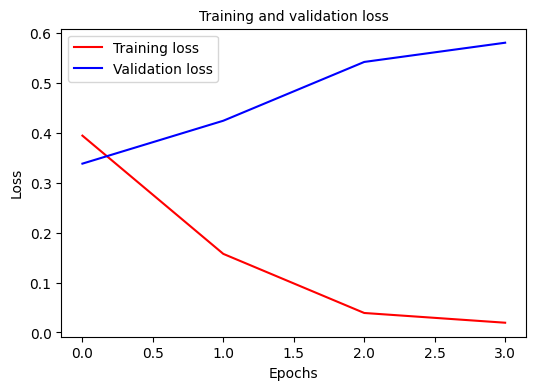

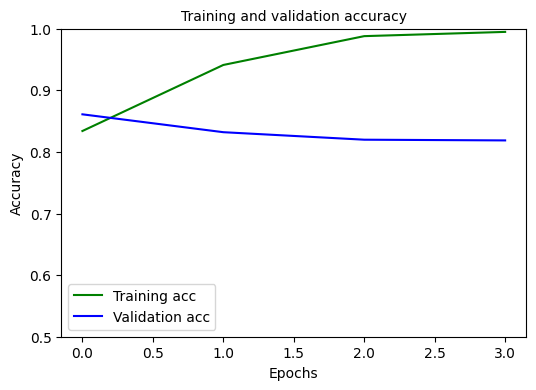

In [119]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Accuracy: 0.8644697145509399
F1 Score: 0.9149679673849738
ROC AUC Score: 0.8828103299303688


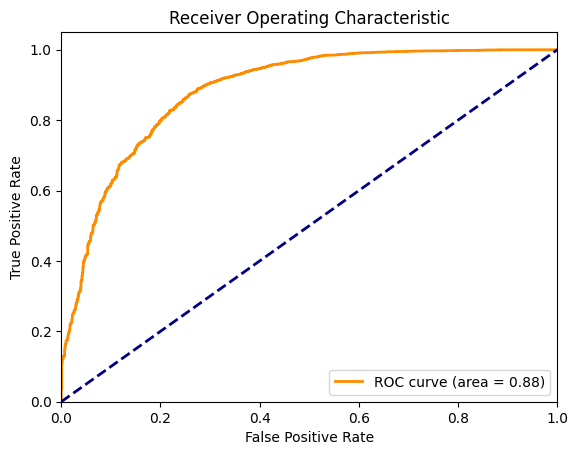

In [118]:
y_pred = model.predict(X_test)

# Округляем вероятности до 0 или 1 т.к. БИНАРНАЯ классификация
y_pred_binary = np.round(y_pred)

# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

# Выводим результаты
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# чем выше ROC AUC тем лучше производительность модели 0.88 хорошо разделяет классы (площадь под кривой является мерой качества классификации)
# точность Accuracy высокая 0.86
# F1 Score гармоническое среднее между точностью и полнотой (0.91 хороший баланс между точностью и полнотой)

In [120]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=128, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(units=64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8019 - loss: 0.4593 - val_accuracy: 0.8584 - val_loss: 0.3406
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9165 - loss: 0.2096 - val_accuracy: 0.8439 - val_loss: 0.3507
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9586 - loss: 0.1151 - val_accuracy: 0.8442 - val_loss: 0.4201
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9801 - loss: 0.0579 - val_accuracy: 0.8271 - val_loss: 0.5184


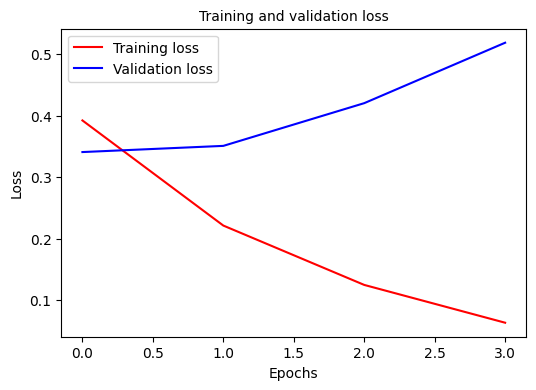

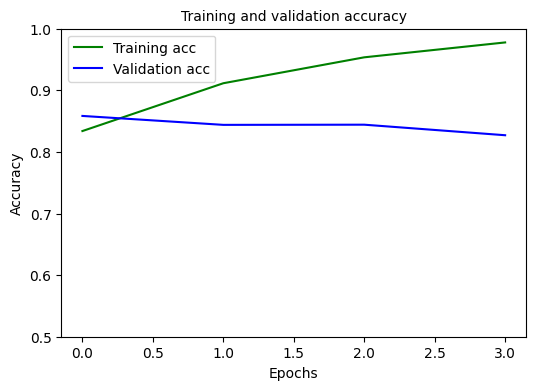

In [121]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8647017869575307
F1 Score: 0.914753618950139
ROC AUC Score: 0.8908012096540654


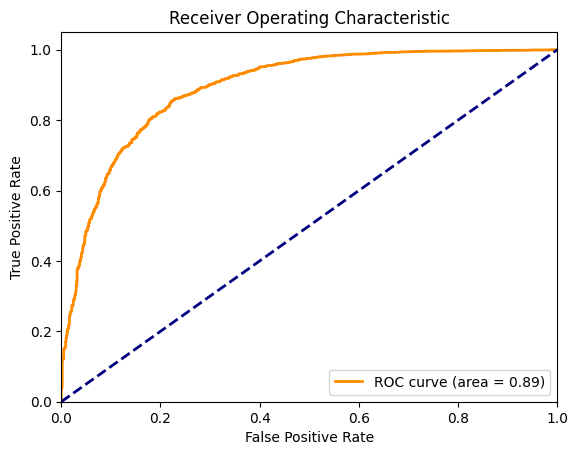

In [122]:
y_pred = model.predict(X_test)

# Округляем вероятности до 0 или 1 т.к. БИНАРНАЯ классификация
y_pred_binary = np.round(y_pred)

# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

# Выводим результаты
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# чем выше ROC AUC тем лучше производительность модели 0.89 хорошо разделяет классы (площадь под кривой является мерой качества классификации)
# точность Accuracy высокая 0.86
# F1 Score гармоническое среднее между точностью и полнотой (0.91 хороший баланс между точностью и полнотой)

In [123]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=input_dim, output_dim=128, input_length=max_length),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GRU(units=64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


460/460 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7989 - loss: 0.4649 - val_accuracy: 0.8645 - val_loss: 0.3352
Epoch 2/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9201 - loss: 0.2008 - val_accuracy: 0.8558 - val_loss: 0.3588
Epoch 3/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9638 - loss: 0.1046 - val_accuracy: 0.8239 - val_loss: 0.4235
Epoch 4/10
460/460 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9823 - loss: 0.0535 - val_accuracy: 0.8341 - val_loss: 0.6064


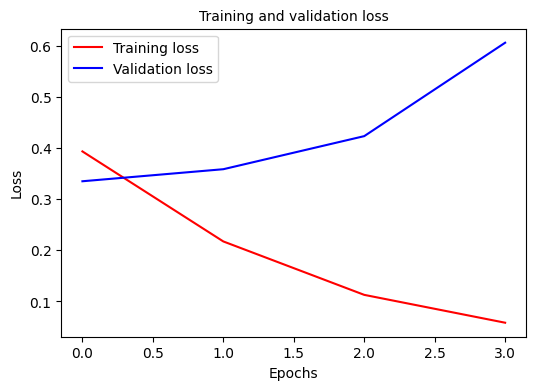

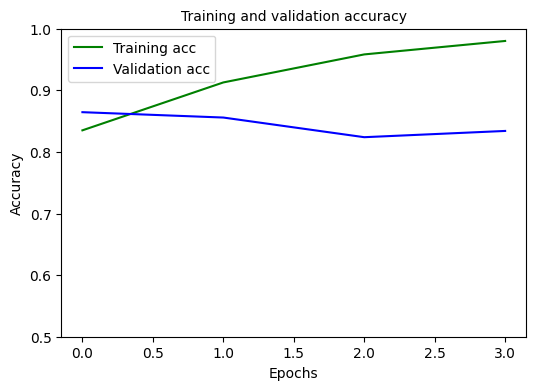

In [124]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Loss', size=10)
plt.legend(prop={'size': 10})
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=10)
plt.xlabel('Epochs', size=10)
plt.ylabel('Accuracy', size=10)
plt.legend(prop={'size': 10})
plt.ylim((0.5,1))
plt.show()

135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.8637734973311674
F1 Score: 0.9147421931735658
ROC AUC Score: 0.8900092727537064


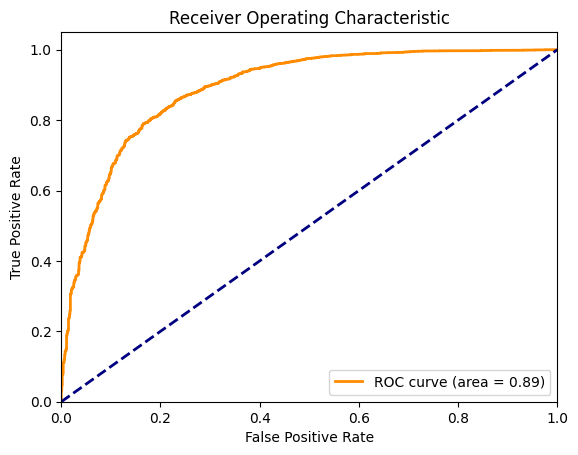

In [125]:
y_pred = model.predict(X_test)

# Округляем вероятности до 0 или 1 т.к. БИНАРНАЯ классификация
y_pred_binary = np.round(y_pred)

# Оцениваем производительность модели
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
roc_auc = roc_auc_score(y_test, y_pred)

# Выводим результаты
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

# Строим ROC-кривую
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
# чем выше ROC AUC тем лучше производительность модели 0.89 хорошо разделяет классы (площадь под кривой является мерой качества классификации)
# точность Accuracy высокая 0.86
# F1 Score гармоническое среднее между точностью и полнотой (0.91 хороший баланс между точностью и полнотой)